In [1]:
#Loading useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import sys
import argparse

#General purpose AI packages
from sklearn.cross_validation import train_test_split,KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import ParameterGrid

#Keras packages
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, ActivityRegularization
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.optimizers import RMSprop
from keras import regularizers 

C:\ProgramData\Anaconda3\envs\PY36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
############## LOSSHISTORY CALLBACK CLASS ######################################
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [3]:
DATAFILE = os.path.join('data','data.csv')
TARGETFILE = os.path.join('data','target.csv')
OUTDIR = os.path.join('results')

In [26]:
############## PREPARING DATA ##################################################
train = pd.read_table(DATAFILE,sep=',')
train = np.asarray(train)

target = pd.read_table(TARGETFILE,sep=',')
target = np.asarray(target)

train_val_size = 0.8 #80% training+validation set and 20% test set
train_size = 0.7 #70% training set and 30% validation set
X_tr_val, X_te, Y_tr_val, Y_te = train_test_split(train, target, train_size=train_val_size, random_state=0)
X_tr, X_val, Y_tr, Y_val = train_test_split(X_tr_val, Y_tr_val, train_size=train_size, random_state=0)
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)

In [38]:
def train_nn(X_tr,Y_tr,X_val,Y_val,params):

    #Build NN
    model = Sequential()
    model.add(Dense(units=params['n_nodes_1'], input_dim=12, activity_regularizer=regularizers.l2(params['regularization_1'])))
    model.add(Activation(params['activation_1']))
    model.add(Dropout(params['dropout_1']))
    model.add(Dense(units=params['n_nodes_2'],activity_regularizer=regularizers.l2(params['regularization_2'])))
    model.add(Activation(params['activation_2']))
    model.add(Dense(units=1))

    opt = RMSprop(lr=params['opt_lr'], rho=params['opt_rho'], epsilon=params['opt_epsilon'], decay=params['opt_decay'])
    model.compile(loss=params['comp_loss'],optimizer=opt)
    
    filepath = os.path.join('results','weights.{epoch:02d}-{val_loss:.2f}.hdf5')
    mdlcheck = ModelCheckpoint(filepath, verbose=0, save_best_only=True)
    mdllosses = LossHistory()
    mdlstop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

    n_epochs = 10000
    n_batch = params['fit_n_batch']
    history = model.fit(X_tr, Y_tr, validation_data = (X_val, Y_val),  epochs = n_epochs, batch_size = n_batch, callbacks = [mdlstop,mdlcheck,mdllosses],verbose = 0)
    return model, mdllosses

In [ ]:
n_nodes_1 = np.array([10, 20, 50])
#n_nodes_1 = np.array([20])
activation_1 = np.array(['linear','sigmoid','relu','tanh'])
#activation_1 = np.array(['relu'])
regularization_1 = np.array([0,0.1,0.25])
#regularization_1 = np.array([0])
dropout_1 = np.array([0,0.1,0.25])
#dropout_1 = np.array([0.1])

n_nodes_2 = np.array([10, 20, 50])
#n_nodes_2 = np.array([50])
activation_2 = np.array(['linear','sigmoid','relu','tanh'])
#activation_2 = np.array(['sigmoid'])
regularization_2 = np.array([0,0.1,0.25])
#regularization_2 = np.array([0.1])

comp_loss = np.array(['mean_squared_error','mean_absolute_error'])
#comp_loss = np.array(['mean_squared_error'])

opt_lr = np.array([0.001])
opt_rho = np.array([0.9]) 
opt_epsilon = np.array([1e-08])
opt_decay = np.array([0.0])

fit_n_batch = np.array([16,32,64])
#fit_n_batch = np.array([16])

grid = [{'n_nodes_1': n_nodes_1, 'activation_1': activation_1, 
         'regularization_1' : regularization_1, 'dropout_1' : dropout_1,
        'n_nodes_2': n_nodes_2, 'activation_2': activation_2, 
         'regularization_2' : regularization_2, 
         'comp_loss' : comp_loss, 
         'opt_lr' : opt_lr, 'opt_rho' : opt_rho, 
         'opt_epsilon' : opt_epsilon, 'opt_decay' : opt_decay,
        'fit_n_batch' : fit_n_batch}]

params = list(ParameterGrid(grid))

In [ ]:
performance = []
i = 1
for p in params:
    print('Testing (',i,' of ',np.shape(params)[0],'): ', p)
    model, loss = train_nn(X_tr,Y_tr,X_val,Y_val,params[0])
    performance.append(min(loss.val_losses))
    i = i+1

Testing ( 1  of  23328 ):  {'activation_1': 'linear', 'activation_2': 'linear', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.0, 'fit_n_batch': 16, 'n_nodes_1': 10, 'n_nodes_2': 10, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.001, 'opt_rho': 0.90000000000000002, 'regularization_1': 0.0, 'regularization_2': 0.0}
Testing ( 2  of  23328 ):  {'activation_1': 'linear', 'activation_2': 'linear', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.0, 'fit_n_batch': 16, 'n_nodes_1': 10, 'n_nodes_2': 10, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.001, 'opt_rho': 0.90000000000000002, 'regularization_1': 0.0, 'regularization_2': 0.10000000000000001}
Testing ( 3  of  23328 ):  {'activation_1': 'linear', 'activation_2': 'linear', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.0, 'fit_n_batch': 16, 'n_nodes_1': 10, 'n_nodes_2': 10, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.001, 'opt_rho': 0.90000000000000002, 'regularization_1': 0.0, 'regularization_2': 0.25}
Testing 


 Score NN:  1482.50726892


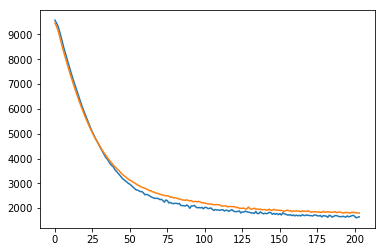

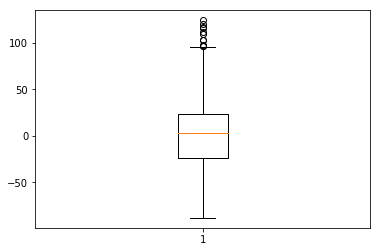

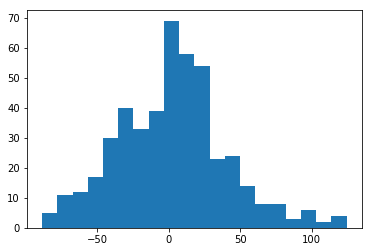

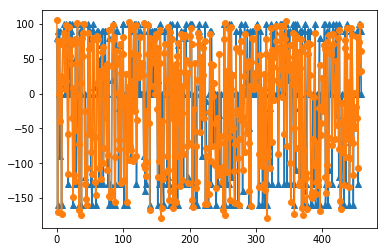

In [36]:
############## EVALUATING RESULTS  #############################################
Y_te = np.squeeze(Y_te)
Y_NN = np.squeeze(model.predict(X_te))

#MSE
print('\n Score NN: ',mean_squared_error(Y_NN,Y_te))

#Plot train and validation losses
plt.plot(loss.losses)
plt.plot(loss.val_losses)
plt.show()

#Boxplot of the difference between actual values and estimates
data_to_plot = [Y_te-Y_NN]
plt.boxplot(data_to_plot)
plt.show()

#Histogram of the difference between actual values and estimates
plt.hist(data_to_plot,bins=20)
plt.show()

#Plot of the actual values and estimates
plt.plot(Y_te, marker='^')
plt.plot(Y_NN, marker='o')
plt.show()

In [42]:
np.shape(params)[0]

3

In [31]:
b = []
b.append(a)
b.append(a)

In [32]:
b

[1760.5109814541743, 1760.5109814541743]